In [2]:
import pandas as pd
import numpy as np

import sys
import os

from pathlib import Path
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load Datasets

In [14]:
# emofilm_info_df = pd.read_csv('D:/Documents/emofilm/data/complete_info.csv')
emofilm_uk_df = pd.read_csv(
    'D:/Programming/nn/emotion_classification/datasets/emofilm_uk_df.csv')
emofilm_df = pd.read_csv(
    'D:/Programming/nn/emotion_classification/datasets/emofilm_df.csv')
emofilm_uk_new_df = pd.read_csv(
    'D:/Programming/nn/emotion_classification/datasets/emofilm_uk_new_df.csv'
)
uk_new_test_df = pd.read_csv(
    'D:/Programming/nn/emotion_classification/datasets/emofilm_uk_new_test_df.csv'
)
ravdess_df = pd.read_csv(
    'D:/Programming/nn/emotion_classification/datasets/ravdess_df.csv')
savee_df = pd.read_csv(
    'D:/Programming/nn/emotion_classification/datasets/savee_df.csv')
tess_df = pd.read_csv(
    'D:/Programming/nn/emotion_classification/datasets/tess_df.csv')
cremad_df = pd.read_csv(
    'D:/Programming/nn/emotion_classification/datasets/cremad_df.csv')

In [15]:
data_df = pd.concat([emofilm_uk_df, emofilm_df, ravdess_df, savee_df, tess_df, cremad_df],
                    axis=0, ignore_index=True)
data_df_no_uk = pd.concat([emofilm_df, ravdess_df, savee_df, tess_df, cremad_df],
                          axis=0, ignore_index=True)
data_df
data_df_uk = pd.concat([emofilm_uk_df, emofilm_uk_new_df])

In [16]:
data_df['emotion'].replace('calm', 'neutral', inplace=True)
data_df_no_uk['emotion'].replace('calm', 'neutral', inplace=True)
emofilm_uk_new_df['emotion'].replace('calm', 'neutral', inplace=True)
uk_new_test_df['emotion'].replace('calm', 'neutral', inplace=True)
data_df_uk['emotion'].replace('calm', 'neutral', inplace=True)

### test tfio


In [11]:
import tensorflow_io as tfio
import tensorflow as tf
# audio = tfio.audio.AudioIOTensor(a[0])
# print(audio)



In [12]:
file_contents = tf.io.read_file(a[0])
wav, sample_rate =  tf.audio.decode_wav(
          file_contents,
          desired_channels=1)

wav = tf.squeeze(wav, axis=-1)
sample_rate = tf.cast(sample_rate, dtype=tf.int64)
wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=22050)
wav = tf.cast(wav, tf.float32) / 32768.0 # division scales the audio values to be between -1.0 and 1.0

Audio(wav, rate=22050)

NameError: name 'a' is not defined

59361

In [ ]:
audio_length = len(wav.numpy())
target_length = 2 * 22050
if audio_length < target_length:
    # Audio is shorter than target, pad with silence
    padding_amount = tf.cast(
        (target_length - audio_length) / 2, dtype=tf.float32)
    padding = tf.zeros_like(wav[:padding_amount])
    fixed_audio = tf.concat([padding, wav, padding], axis=0)
elif audio_length > target_length:
    # Audio is longer than target, trim from the beginning and end
    start_trim = tf.cast(tf.random.uniform(
        [], minval=0, maxval=audio_length - target_length, dtype=tf.float32), dtype=tf.int32)
    end_trim = start_trim + tf.cast(target_length, dtype=tf.int32)
    fixed_audio = wav[start_trim:end_trim]
Audio(fixed_audio, rate=22050)

(64, 64)


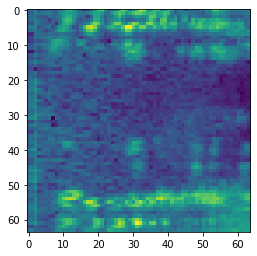

In [ ]:
# spectrogram = tfio.audio.spectrogram(
#     fixed_audio, nfft=512, window=512, stride=256)

spectrogram = tfio.audio.spectrogram(
    fixed_audio, nfft=512, window=512, stride=690)
# n_fft=1024, hop_length=690, n_mels=64
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=22050, mels=64, fmin=0, fmax=8000)

dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)
print(dbscale_mel_spectrogram.shape)
plt.figure(figsize=(4,15))
plt.imshow(dbscale_mel_spectrogram.numpy())

(128, 128)


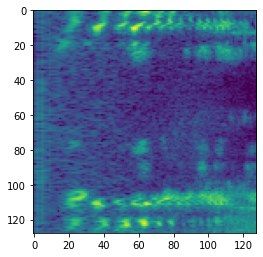

In [ ]:
# spectrogram = tfio.audio.spectrogram(
#     fixed_audio, nfft=512, window=512, stride=256)

spectrogram = tfio.audio.spectrogram(
    fixed_audio, nfft=1024, window=512, stride=345)
# n_fft=1024, hop_length=690, n_mels=64
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=22050, mels=128, fmin=0, fmax=8000)

dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)
print(dbscale_mel_spectrogram.shape)
plt.figure(figsize=(4,15))
plt.imshow(dbscale_mel_spectrogram.numpy())

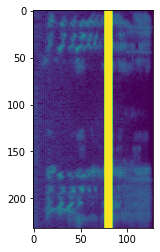

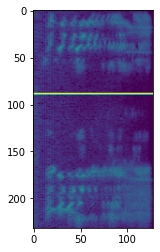

In [ ]:
# Freq masking
freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=10)

plt.figure()
plt.imshow(freq_mask.numpy())

# Time masking
time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param=10)
plt.figure()
plt.imshow(time_mask.numpy())

In [ ]:
# audio_slice = audio[:audio.rate * 2]

# # remove last dimension
# audio_tensor = tf.squeeze(audio_slice, axis=[-1])
# audio_tensor = tfio.audio.resample(audio_tensor, rate_in=audio.rate, rate_out=22050)
# print(audio_tensor)

tf.Tensor([-19 -21 -18 ... 184 265  63], shape=(88200,), dtype=int16)


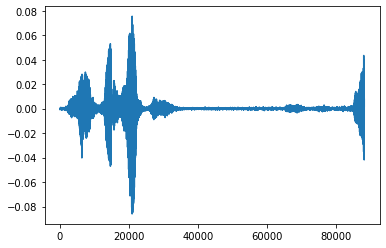

In [ ]:
tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())

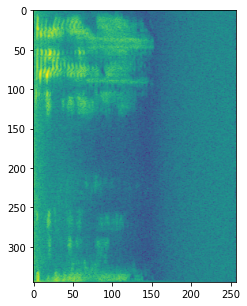

In [ ]:
# Convert to spectrogram
spectrogram = tfio.audio.spectrogram(
    tensor, nfft=512, window=512, stride=256)

plt.figure(figsize=(10,5))
plt.imshow(tf.math.log(spectrogram).numpy())

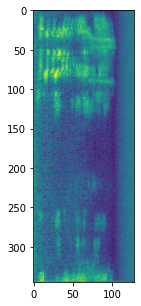

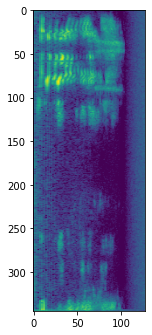

In [ ]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure(figsize=(10,5))
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)

plt.figure(figsize=(2,15))
plt.imshow(dbscale_mel_spectrogram.numpy())

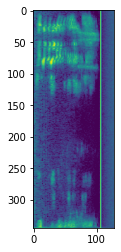

In [ ]:
# Freq masking
freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=10)

plt.figure()
plt.imshow(freq_mask.numpy())

(345, 128)


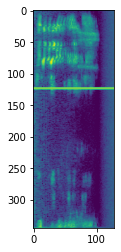

In [ ]:
# Time masking
time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param=10)
plt.figure()
plt.imshow(time_mask.numpy())

In [ ]:
data_df[0 * 5:(0 + 1) * 5]

emotion                                               path
0      fear  D:/Programming/nn/emotion_classification/datas...
1      fear  D:/Programming/nn/emotion_classification/datas...
2  contempt  D:/Programming/nn/emotion_classification/datas...
3  contempt  D:/Programming/nn/emotion_classification/datas...
4  contempt  D:/Programming/nn/emotion_classification/datas...

In [ ]:
np.array(data_df['emotion'])

array(['fear', 'fear', 'contempt', ..., 'happiness', 'neutral', 'sadness'],
      dtype=object)

### load data

In [3]:
length_3s = 3 * 22050
length_2s = 2 * 22050

In [21]:
from pandas import DataFrame


def load_and_scale(df: DataFrame, fixed_length: int, scale=True):
    data = []
    labels = []
    a = True
    for _, row in df.iterrows():
        audio, sample_rate = librosa.load(row['path'])
        if a:
            print(sample_rate)
            a = False
        audio = librosa.util.fix_length(audio, size=fixed_length)
        if scale:
            audio = audio / 32768.0
        data.append(audio)
        labels.append(row['emotion'])

    data = np.array(data)
    labels = np.array(labels)
    data_shape = data.shape

    # if scale:
    #     scaler = StandardScaler()
    #     data = scaler.fit_transform(data)

    return [data, labels]

In [22]:
scaled, labels = load_and_scale(data_df_no_uk, length_2s, scale=False)
print(scaled.shape, labels)

22050
(13277, 44100) ['fear' 'fear' 'fear' ... 'happiness' 'neutral' 'sadness']


In [23]:
uk_scaled, uk_labels = load_and_scale(data_df_uk, length_2s, scale=False)
print(uk_scaled.shape)

22050
(195, 44100)


In [24]:
scaled_uk_test_only, labels_uk_test_only = load_and_scale(uk_new_test_df, length_2s, scale=False)
print(scaled_uk_test_only.shape)

22050
(39, 44100)


In [25]:
Audio(scaled_uk_test_only[1], rate=22050)

for df

In [ ]:
# from sklearn.model_selection import train_test_split

# train_df, test_l_df = train_test_split(data_df, test_size=0.3)
# val_df, test_df = train_test_split(test_l_df, test_size=0.4)
# train_df_no_uk, test_df_no_uk = train_test_split(data_df_no_uk, test_size=0.3)

# print(f'train: {train_df.shape}\nval: {val_df.shape}\ntest: {test_df.shape}\n\ntest(no split): {test_l_df.shape}')

In [ ]:
# for regular data:
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    scaled, labels, test_size=0.2, random_state=13)
x_val_scaled, x_test_scaled, y_val_scaled, y_test_scaled = train_test_split(
    x_test_scaled, y_test_scaled, test_size=0.5, random_state=9)
print(f'train: {x_train_scaled.shape, y_train_scaled.shape}\nval: {x_val_scaled.shape, y_val_scaled.shape}\ntest: {x_test_scaled.shape, y_test_scaled.shape}\n')


train: ((10621, 44100), (10621,))
val: ((1328, 44100), (1328,))
test: ((1328, 44100), (1328,))



In [ ]:
# for uk_new data:
x_train_scaled_uk, x_val_scaled_uk, y_train_scaled_uk, y_val_scaled_uk = train_test_split(
    uk_scaled, uk_labels, test_size=0.3, random_state=3)
print(f'train: {x_train_scaled_uk.shape, y_train_scaled_uk.shape}\nval: {x_val_scaled_uk.shape, y_val_scaled_uk.shape}\n')

train: ((77, 44100), (77,))
val: ((34, 44100), (34,))



In [ ]:
from sklearn.preprocessing import scale
a, sr = librosa.load(data_df['path'][1])
a = librosa.util.fix_length(a, size=length_2s)
print(a.shape, sr)

(44100,) 22050


## Define functions

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data


def invert_polarity(data):
    return data * -1


def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


# taking any example and checking for techniques.
path = np.array(data_df.path)[1]
data, sample_rate = librosa.load(path)

In [ ]:
def extract_zcr(data):
    return librosa.feature.zero_crossing_rate(y=data)


def extract_chroma_stft(data, sr):
    return librosa.feature.chroma_stft(y=data, sr=sr)


def extract_mfcc(data, sr):
    return librosa.feature.mfcc(y=data, sr=sr)


def extract_rms(data):
    return librosa.feature.rms(y=data)


def extract_melspectrogram(data, sr):
    return librosa.feature.melspectrogram(y=data, sr=sr, n_fft=512)

In [ ]:
# This code was adapted from Nicolas Gervais on https://stackoverflow.com/questions/59241216/padding-numpy-arrays-to-a-specific-size on 1/10/2021
import math
from numpy import ndarray


def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2, 0)
    aa = max(0, xx - a - h)
    b = max(0, (yy - w) // 2)
    bb = max(yy - b - w, 0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')


def fix_length(data: ndarray, length: int):
    fixed = data.reshape(len(data), 1)
    fixed = padding(fixed, length, 1)
    fixed = fixed.reshape(len(fixed))

    return fixed


def repeat_audio(data: ndarray, sr: int, duration_millis: int):

    length = int(duration_millis/1000*sr)
    n = math.ceil(duration_millis/1000*sr/len(data))
    fixed = np.tile(data, n)
    fixed = fixed[:length]

    return fixed

width2 = int(required_duration_millis/1000*sr)
width2

In [ ]:
def extract_features(data):

    result = np.array([])

    # ZCR
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(
        S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(
        y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def extract_features_v2(data):

    result = np.array([])

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(
        y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def extract_features_v3(data):
    mel = librosa.feature.melspectrogram(
        y=data, sr=sr, n_fft=2048, hop_length=1024)
    mel = librosa.power_to_db(mel, ref=np.max)
    print(mel.shape)
    mel = mel.flatten()
    return np.array(mel)

In [ ]:
import features_1d as ft


def get_features(path, augment=True):

    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    if (augment):

        noise_data = noise(data)
        res2 = extract_features(noise_data)
        result = np.vstack((result, res2))  # stacking vertically

        invert_data = invert_polarity(data)
        res3 = extract_features(invert_data)
        result = np.vstack((result, res3))  # stacking vertically
        return result

    result = np.reshape(result, (1, len(result)))

    return result


def get_features_1d_v2(path, fixed_length=(3 * 22050), augment=True):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)
    print(f'data: {data.shape}')
    data = librosa.util.fix_length(data, size=fixed_length)
    print(f'data: {data.shape}')
    # without augmentation
    res1 = ft.extract_features_1d_v2(data)
    result = np.array(res1)
    if (augment):
        noise_data = noise(data)
        res1 = ft.extract_features_1d_v2(noise_data)
        result = np.vstack((result, res1))  # stacking vertically
        invert_data = invert_polarity(data)
        res1 = ft.extract_features_1d_v2(invert_data)
        result = np.vstack((result, res1))  # stacking vertically
        return result

    result = np.reshape(result, (1, len(result)))
    return result


def get_features_1d_v3(path, extract_function, fixed_length, augment=True):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)
    data = librosa.util.fix_length(data, size=fixed_length)
    # without augmentation
    res1 = extract_function(data)
    result = np.array(res1)
    if (augment):
        noise_data = noise(data)
        res1 = extract_function(noise_data)
        result = np.vstack((result, res1))  # stacking vertically
        invert_data = invert_polarity(data)
        res1 = extract_function(invert_data)
        result = np.vstack((result, res1))  # stacking vertically
        return result

    result = np.reshape(result, (1, len(result)))
    return result


def get_features_1d_v4(path, extract_function, fixed_length, augment=True):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)
    data = librosa.util.fix_length(data, size=fixed_length)
    # without augmentation
    res1 = extract_function(data)
    result = np.array(res1)
    if (augment):
        noise_data = noise(data)
        res1 = extract_function(noise_data)
        result = np.vstack((result, res1))  # stacking vertically
        invert_data = invert_polarity(data)
        res1 = extract_function(invert_data)
        result = np.vstack((result, res1))  # stacking vertically
        shifted_data = shift(data)
        res1 = extract_function(shifted_data)
        result = np.vstack((result, res1))  # stacking vertically
        return result

    result = np.reshape(result, (1, len(result)))
    return result

In [ ]:
def save_features(dataframe, path, augment=True):
    X, y = [], []
    for i, row in dataframe.iterrows():
        features = get_features(row['path'], augment)
        for f in features:
            X.append(f)
            y.append(row['emotion'])
    res_df = pd.DataFrame(X)
    res_df['labels'] = y
    res_df.to_csv(path, index=False)
    print(res_df.info())


def save_features_1d_v2(dataframe, path, augment=True):
    X, y = [], []
    for i, row in dataframe.iterrows():
        features = get_features_1d_v2(
            row['path'], fixed_length=int(3*22050), augment=augment)
        for f in features:
            X.append(f)
            y.append(row['emotion'])

    res_df = pd.DataFrame(X)
    res_df['labels'] = y

    res_df.to_csv(path, index=False)
    print(res_df.info())


def save_features_1d_v3(dataframe, path, extract_function, fixed_length, augment=True):
    X, y = [], []
    for _, row in dataframe.iterrows():
        features = get_features_1d_v3(
            row['path'], extract_function=extract_function, fixed_length=fixed_length, augment=augment)
        for f in features:
            X.append(f)
            y.append(row['emotion'])

    res_df = pd.DataFrame(X)
    res_df['labels'] = y

    res_df.to_csv(path, index=False)
    print(res_df.info())
    return res_df


def save_features_1d_v4(dataframe, path, extract_function, fixed_length, augment=True):
    X, y = [], []
    for _, row in dataframe.iterrows():
        features = get_features_1d_v4(
            row['path'], extract_function=extract_function, fixed_length=fixed_length, augment=augment)
        for f in features:
            X.append(f)
            y.append(row['emotion'])

    res_df = pd.DataFrame(X)
    res_df['labels'] = y

    res_df.to_csv(path, index=False)
    print(res_df.info())
    return res_df

## Tests

In [26]:
import extraction_utils as el

In [27]:
uk_scaled[0].shape

(44100,)

In [28]:
Audio(uk_scaled[0], rate=22050)

In [25]:
mfcc_features_v2 = pd.read_csv("./features/features-train-all-mfcc-v2.csv")
mfcc_features_v4 = pd.read_csv("./features/features-train-all-mfcc-v4.csv")

In [39]:
x_train2 = mfcc_features_v2.iloc[:, :-1].values
x_train4 = mfcc_features_v4.iloc[:, :-1].values

In [40]:
x_train2 = np.reshape(x_train2, (len(x_train2), 64, 64))
x_train4 = np.reshape(x_train4, (len(x_train4), 64, 64))

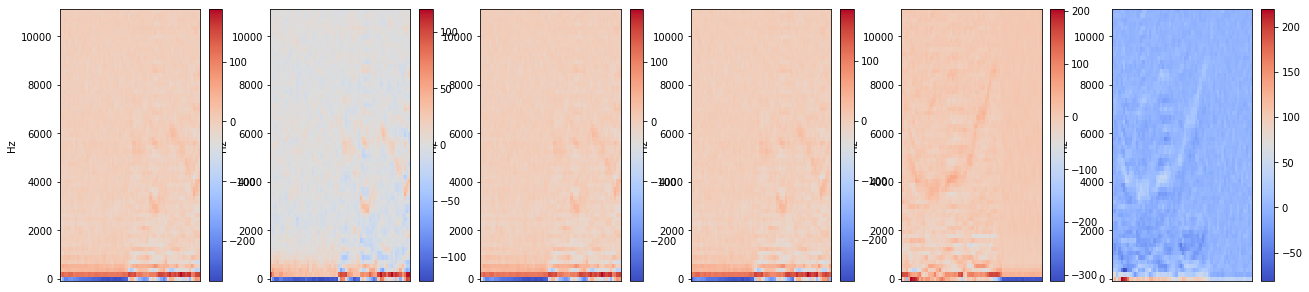

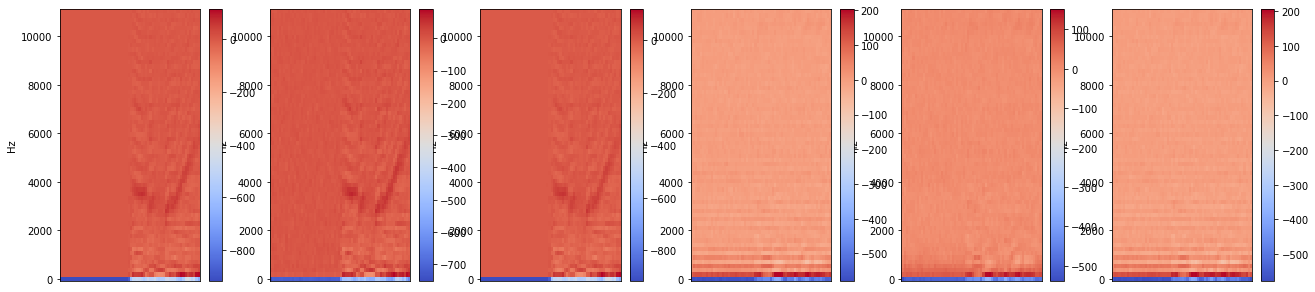

In [53]:
l=12
r=18
x_train_samples2 = x_train2[l:r]
x_train_samples4 = x_train4[l:r]

fig, axs = plt.subplots(1, len(x_train_samples2), figsize=(22, 5))
for i in range(len(x_train_samples2)):
	img = librosa.display.specshow(x_train_samples2[i], y_axis='hz', ax=axs[i])
	fig.colorbar(img, ax=[axs[i]])

plt.show()

fig, axs = plt.subplots(1, len(x_train_samples4), figsize=(22, 5))
for i in range(len(x_train_samples4)):
	img = librosa.display.specshow(x_train_samples4[i], y_axis='hz', ax=axs[i])
	fig.colorbar(img, ax=[axs[i]])

plt.show()

(64, 64)
(64, 64)
(64, 64)


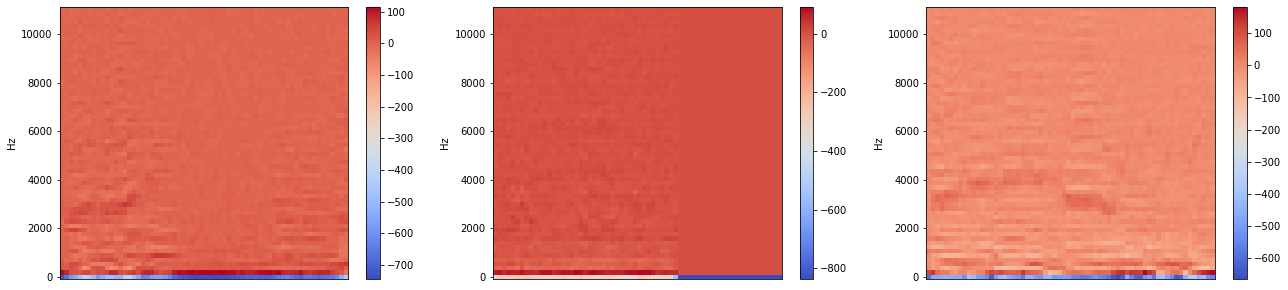

In [33]:
uk_samples = uk_scaled[:3]

fig, axs = plt.subplots(1, len(uk_samples), figsize=(22, 5))
for i in range(len(uk_samples)):
	mfcc_flat = el.__get_mfcc_flat(uk_samples[i], 22050)
	mfcc = np.reshape(mfcc_flat, (64, 64))
	img = librosa.display.specshow(mfcc, y_axis='hz', ax=axs[i])
	fig.colorbar(img, ax=[axs[i]])

plt.show()

In [15]:
max_length = 110250
max_i = 14
sample_rate = 22050
max_duration_s = librosa.get_duration(path=data_df['path'][14])
required_duration_millis = 5000

width = 216  # 5 seconds of adio is 216
height = 128  # melspectrogram height is 128

duration = int(required_duration_millis/1000*sample_rate)

load audio file

In [18]:
from sklearn.preprocessing import scale
a, sr = librosa.load(uk_new_test_df['path'][0])
a = librosa.util.fix_length(a, size=length_2s)
print(a.shape, sr)

(44100,) 22050


### mfcc

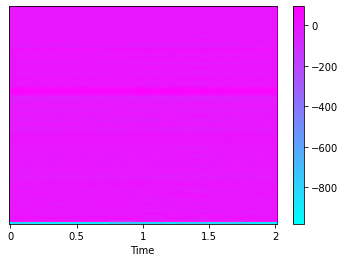

In [19]:
hop_length = 512  # the default spacing between frames
n_fft = 255  # number of samples

MFCCs = librosa.feature.mfcc(
    y=a, n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
librosa.display.specshow(MFCCs, sr=sr, cmap='cool',
                         hop_length=hop_length, x_axis='time')
plt.colorbar()
plt.show()

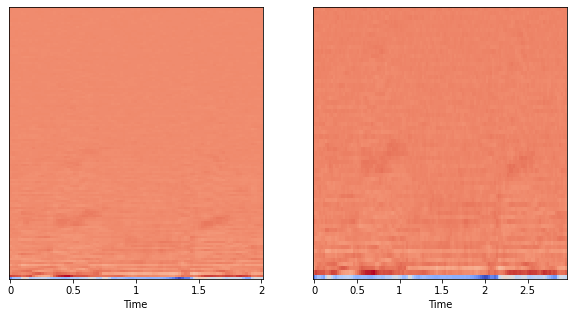

(64, 128)


In [20]:
sample = scaled[5]
mfccs_basic = librosa.feature.mfcc(y=sample, sr=sr, n_mfcc=128)
mfccs = librosa.feature.mfcc(
    y=sample, sr=sr, n_mfcc=64, n_fft=1024, hop_length=346)
# hop_length = 690 for 2 second framgent
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
librosa.display.specshow(mfccs_basic, sr=sr, x_axis='time', ax=axs[0])
librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=axs[1])
plt.show()
print(mfccs.shape)

(64, 64) (20,)


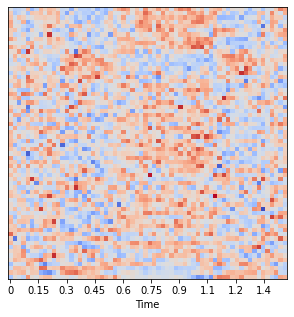

In [164]:
mfccs = librosa.feature.mfcc(
    y=scaled[5], sr=sr, n_mfcc=64, n_fft=255, hop_length=690)
mfccs = scale(mfccs, axis=1)
mfcc_m = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
print(mfccs.shape, mfcc_m.shape)

plt.figure(figsize=(5, 5))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

(128, 87) (20,)


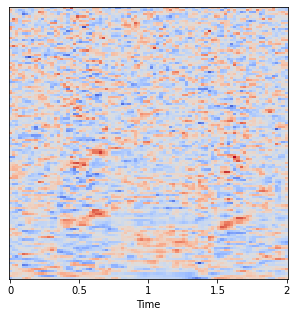

In [149]:
mfccs = librosa.feature.mfcc(y=scaled[5], sr=sr, n_mfcc=128)
mfccs = scale(mfccs, axis=1)
mfcc_m = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
print(mfccs.shape, mfcc_m.shape)

plt.figure(figsize=(5, 5))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

### melspectrogram

(64, 64) (128,)


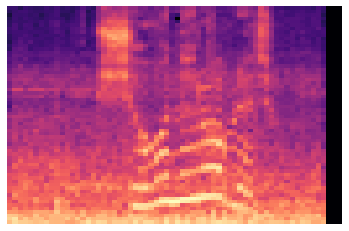

In [32]:
# mel = librosa.feature.melspectrogram(y=a, sr=sr)
mel = librosa.feature.melspectrogram(
    y=a, sr=sr, n_fft=1024, hop_length=690, n_mels=64)
mel_spect = librosa.power_to_db(mel, ref=np.max)
mel_m = np.mean(librosa.feature.melspectrogram(y=a, sr=sr).T, axis=0)
print(mel.shape, mel_m.shape)
librosa.display.specshow(mel_spect, sr=sr, x_axis='time')
# librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time')
# plt.show()
plt.axis('off')
plt.savefig(f'test.png')

## Save features

## save v1

### mel only

extraction functions:

In [18]:
sr = 22050

# 64 * 64
# n_mels=64, n_fft=1024, hop_length=690

# 128 * 128
# n_mels=128, n_fft=1024, hop_length=345


def extract_mel_flat(data, n_mels=64, n_fft=1024, hop_length=690):
    mel = librosa.feature.melspectrogram(
        y=data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel = librosa.power_to_db(mel, ref=np.max)
    print(mel.shape)
    return mel.flatten()


def get_features_1d_v5_mel(data, augment=True):
    res1 = extract_mel_flat(data)
    result = np.array(res1)
    if (augment):
        noise_data = noise(data)
        res1 = extract_mel_flat(noise_data)
        result = np.vstack((result, res1))  # stacking vertically

        invert_data = invert_polarity(data)
        res1 = extract_mel_flat(invert_data)
        result = np.vstack((result, res1))  # stacking vertically

        shifted_data = shift(data)
        res1 = extract_mel_flat(shifted_data)
        result = np.vstack((result, res1))  # stacking vertically

        return result

    result = np.reshape(result, (1, len(result)))
    return result


def save_features_1d_v5_mel(data_arr, labels_arr, path, augment=True, shuffle=True):
    X, y = [], []
    for data, label in zip(data_arr, labels_arr):
        features = get_features_1d_v5_mel(data, augment=augment)
        for f in features:
            X.append(f)
            y.append(label)

    res_df = pd.DataFrame(X)
    res_df['labels'] = y

    res_df = res_df.sample(frac=1, random_state=1).reset_index(
        drop=True)  # shuffle dataframe
    res_df.to_csv(path, index=False)

    print(res_df.info())
    return res_df

In [35]:
# n_fft=1024, hop_length=345, n_mels=64  # for 2 second framgent

save_features_1d_v5_mel(
    x_train_scaled, y_train_scaled, './features/features-train-no-uk-mel-v4.csv')

(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)

KeyboardInterrupt: 

In [36]:
save_features_1d_v5_mel(
    x_val_scaled, y_val_scaled, './features/features-val-no-uk-mel-v4.csv', augment=False)

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(

0          1          2          3          4          5  \
0    -74.949203 -53.868366 -54.829929 -52.759609 -56.343937 -50.187191   
1    -47.697681 -48.268555 -45.077023 -47.591335 -49.974026 -49.778393   
2    -29.795145 -21.894676 -25.317427 -30.896404 -29.796400 -24.385988   
3    -48.149509 -41.033524 -41.765797 -42.304779 -38.763550 -42.316673   
4    -22.069233 -22.478064 -22.493296 -22.553883 -22.577642 -22.478043   
...         ...        ...        ...        ...        ...        ...   
1323 -44.652195 -42.194855 -37.066189 -35.740303 -35.360397 -43.570805   
1324 -28.913589 -19.373505 -21.328018 -22.067869 -25.028708 -17.141541   
1325 -59.897537 -57.626060 -55.640495 -57.880005 -59.976700 -59.485916   
1326 -38.762196 -30.127331 -27.900642 -31.414631 -31.526199 -29.109322   
1327 -67.253258 -65.817902 -69.793030 -71.028030 -70.113358 -72.899628   

              6          7          8          9  ...       4087       4088  \
0    -48.478371 -51.498264 -51.717102 -50.455486  ... -65.588882 -61.324158   
1    -44.405151 -46.208473 -37.094463 -47.666618  ... -79.115829 -79.132629   
2    -27.600941 -25.264166 -24.455811 -26.048651  ... -80.000000 -80.000000   
3    -41.984261 -45.649651 -42.460602 -43.803249  ... -80.000000 -80.000000   
4    -22.494612 -22.599709 -22.590757 -22.643227  ... -80.000000 -80.000000   
...         ...        ...        ...        ...  ...        ...        ...   
1323 -41.313892 -39.567055 -35.611904 -42.450592  ... -73.307320 -80.000000   
1324 -16.376360 -20.673286 -16.098553 -18.801086  ... -80.000000 -80.000000   
1325 -62.358513 -46.769920 -48.007095 -53.236412  ... -80.000000 -80.000000   
1326 -33.610424 -27.614277 -28.295259 -29.472828  ... -80.000000 -80.000000   
1327 -68.628410 -69.413101 -66.857925 -63.473839  ... -58.539528 -56.848915   

           4089       4090       4091       4092       4093       4094  \
0    -55.057781 -46.863098 -45.990780 -52.739044 -63.578968 -50.699120   
1    -78.371452 -74.290405 -76.849976 -78.928062 -79.437500 -80.000000   
2    -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
3    -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
4    -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
...         ...        ...        ...        ...        ...        ...   
1323 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
1324 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
1325 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
1326 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
1327 -50.278381 -53.779842 -66.307152 -70.641273 -50.014538 -65.087479   

           4095     labels  
0    -59.658844   surprise  
1    -80.000000    sadness  
2    -80.000000    neutral  
3    -80.000000      anger  
4    -80.000000    sadness  
...         ...        ...  
1323 -80.000000    sadness  
1324 -80.000000    sadness  
1325 -80.000000  happiness  
1326 -80.000000    neutral  
1327 -56.277222  happiness  

[1328 rows x 4097 columns]

In [37]:
save_features_1d_v5_mel(
    x_test_scaled, y_test_scaled, './features/features-test-no-uk-mel-v4.csv', augment=False)

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(

0          1          2          3          4          5  \
0    -29.261292 -30.898808 -28.297522 -27.039103 -26.733250 -25.140432   
1    -29.116043 -28.644032 -33.096859 -28.662342 -32.677895 -29.143589   
2    -37.766582 -29.112082 -43.094574 -41.032875 -35.918404 -31.844275   
3    -28.863848 -29.770578 -33.417469 -31.536831 -24.945915 -31.813471   
4    -34.520588 -35.796505 -36.619926 -34.380184 -33.755547 -39.436268   
...         ...        ...        ...        ...        ...        ...   
1323 -42.361553 -34.534935 -35.716122 -34.761326 -37.085049 -38.187572   
1324 -20.796154 -15.675453 -19.937778 -26.742802 -15.145028 -22.175659   
1325 -34.048965 -32.201523 -27.944294 -25.321650 -32.188526 -25.630503   
1326 -31.764519 -30.268307 -26.264729 -27.014004 -31.179325 -29.607067   
1327 -42.028893 -43.738670 -39.640411 -38.791882 -43.181400 -37.440708   

              6          7          8          9  ...       4087       4088  \
0    -27.769318 -26.266052 -26.594572 -24.362265  ... -80.000000 -80.000000   
1    -28.213158 -37.116528 -33.286003 -30.239220  ... -80.000000 -80.000000   
2    -37.019608 -35.760929 -29.834566 -31.915703  ... -80.000000 -78.917320   
3    -25.609324 -26.352150 -28.946976 -31.830135  ... -80.000000 -80.000000   
4    -39.810589 -31.305492 -32.373199 -36.612160  ... -80.000000 -80.000000   
...         ...        ...        ...        ...  ...        ...        ...   
1323 -39.208073 -36.073322 -35.131180 -24.572857  ... -56.424355 -56.507618   
1324 -28.596123 -20.095068 -14.546517 -18.436953  ... -80.000000 -80.000000   
1325 -22.697977 -24.781967 -28.900402 -24.422176  ... -80.000000 -80.000000   
1326 -31.378941 -30.999546 -27.836472 -33.724720  ... -80.000000 -80.000000   
1327 -40.733040 -41.159622 -39.832970 -39.735687  ... -80.000000 -80.000000   

           4089       4090     4091       4092       4093       4094  \
0    -80.000000 -80.000000 -80.0000 -80.000000 -80.000000 -80.000000   
1    -80.000000 -80.000000 -80.0000 -80.000000 -80.000000 -80.000000   
2    -80.000000 -80.000000 -80.0000 -80.000000 -80.000000 -80.000000   
3    -80.000000 -80.000000 -80.0000 -80.000000 -80.000000 -80.000000   
4    -80.000000 -80.000000 -80.0000 -80.000000 -80.000000 -80.000000   
...         ...        ...      ...        ...        ...        ...   
1323 -58.803909 -53.918087 -60.1208 -57.197441 -57.527199 -71.499321   
1324 -80.000000 -80.000000 -80.0000 -80.000000 -80.000000 -80.000000   
1325 -80.000000 -80.000000 -80.0000 -80.000000 -80.000000 -80.000000   
1326 -80.000000 -80.000000 -80.0000 -80.000000 -80.000000 -80.000000   
1327 -80.000000 -80.000000 -80.0000 -80.000000 -80.000000 -80.000000   

           4095     labels  
0    -80.000000    neutral  
1    -80.000000       fear  
2    -80.000000    sadness  
3    -80.000000    neutral  
4    -80.000000    neutral  
...         ...        ...  
1323 -71.168655    neutral  
1324 -80.000000  happiness  
1325 -80.000000    neutral  
1326 -80.000000    neutral  
1327 -80.000000      anger  

[1328 rows x 4097 columns]

In [38]:
save_features_1d_v5_mel(
    x_train_scaled_uk, y_train_scaled_uk, './features/features-train-uk-new-mel-v4.csv')

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(

0          1          2          3          4          5  \
0   -15.293223 -15.109121 -16.179355 -19.419735 -16.101288 -11.504811   
1   -44.286900 -32.615620 -36.063610 -31.264805 -30.923965 -33.795135   
2   -37.721058 -51.089066 -48.060928 -42.446724 -47.262867 -41.273701   
3   -45.501003 -51.281719 -44.482040 -50.834286 -42.854301 -29.534887   
4   -24.301556 -27.454912 -27.342602 -26.749693 -19.213598 -22.636442   
..         ...        ...        ...        ...        ...        ...   
303 -30.079088 -21.301098 -18.545494 -20.620901 -38.109516 -31.204601   
304 -42.378288 -29.540039 -30.034994 -34.103146 -27.885984 -28.294790   
305 -15.316483 -14.995931 -16.155970 -19.387367 -16.068323 -11.497013   
306 -35.944485 -32.890926 -34.815144 -39.520004 -41.066879 -38.110920   
307 -37.594441 -30.433837 -26.910021 -32.207290 -30.655047 -33.836801   

             6          7          8          9  ...       4087       4088  \
0    -6.540537 -11.846098  -9.405376  -6.157541  ... -38.115093 -45.401800   
1   -33.169617 -33.239410 -32.690651 -36.158512  ... -77.033646 -64.684418   
2   -47.678337 -44.860561 -55.525490 -53.948589  ... -80.000000 -80.000000   
3   -33.770996 -42.890888 -38.399200 -47.812046  ... -62.726025 -55.798004   
4   -17.764086 -22.479893 -24.112955 -28.892054  ... -40.365360 -47.401752   
..         ...        ...        ...        ...  ...        ...        ...   
303 -34.761295 -31.196850 -34.809830 -39.732994  ... -80.000000 -80.000000   
304 -30.492285 -29.638681 -32.704937 -25.530462  ... -78.753929 -77.523308   
305  -6.540339 -11.817851  -9.383748  -6.170609  ... -38.231407 -45.133217   
306 -39.885712 -34.351120 -36.149101 -39.412716  ... -43.895931 -45.132088   
307 -29.855548 -29.628062 -27.784659 -27.434730  ... -28.097035 -28.361294   

          4089       4090       4091       4092       4093       4094  \
0   -44.881371 -52.326014 -49.089576 -44.959798 -53.980293 -53.045105   
1   -64.842926 -65.749062 -77.465500 -72.790573 -70.179611 -67.486038   
2   -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
3   -62.777355 -49.377785 -59.361973 -62.667809 -65.425476 -72.178108   
4   -44.168343 -43.381565 -63.547718 -42.257610 -50.831295 -48.739883   
..         ...        ...        ...        ...        ...        ...   
303 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
304 -72.889801 -76.819878 -74.760780 -76.023468 -74.505714 -72.673882   
305 -46.006207 -59.719452 -53.088013 -45.490608 -78.728027 -78.329491   
306 -59.574413 -80.000000 -80.000000 -76.015823 -71.991280 -80.000000   
307 -31.097093 -27.996835 -29.506397 -30.622660 -29.985067 -29.318916   

          4095     labels  
0   -47.195769      anger  
1   -78.369278    sadness  
2   -80.000000       fear  
3   -59.919365       fear  
4   -62.311371       fear  
..         ...        ...  
303 -51.176113       fear  
304 -73.159370    sadness  
305 -48.639992      anger  
306 -68.328835  happiness  
307 -28.170401   contempt  

[308 rows x 4097 columns]

In [39]:
save_features_1d_v5_mel(
    x_val_scaled_uk, y_val_scaled_uk, './features/features-val-uk-new-mel-v4.csv', augment=False)

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Columns: 4097 entries, 0 to labels
dtypes: float32(4096), object(1)
memory usage: 544.4+ KB
None


0          1          2          3          4          5  \
0  -62.260155 -46.624859 -48.659977 -48.186707 -41.491879 -42.743671   
1  -35.668068 -24.075407 -24.143843 -27.791187 -27.541763 -26.561577   
2  -36.220631 -29.693714 -33.305328 -36.617485 -36.888851 -34.288200   
3  -24.844187 -17.986366 -30.750044 -30.637238 -36.888443 -38.706223   
4  -34.450237 -36.468822 -30.648787 -26.067633 -25.871019 -23.290651   
5  -72.760620 -59.424622 -51.620644 -43.504051 -45.613632 -46.104874   
6  -59.197495 -53.230030 -53.826893 -57.109718 -65.693825 -58.923306   
7  -54.625401 -52.687469 -48.459801 -44.181786 -43.692173 -40.867470   
8  -21.750141  -9.865758  -7.995702 -16.115780  -9.604650  -5.198550   
9  -35.729797 -37.188957 -27.573811 -28.270473 -25.717323 -27.007523   
10 -31.585403 -29.339336 -19.723095 -18.134705 -17.543015 -17.009140   
11 -46.186554 -45.318958 -41.075581 -49.275188 -43.318737 -44.148708   
12 -69.891556 -44.720932 -47.437164 -41.820686 -42.791004 -45.400940   
13 -42.354946 -36.823082 -42.636360 -34.192505 -29.936975 -31.254702   
14 -40.724888 -36.562481 -33.481144 -39.438999 -36.823700 -40.494270   
15 -58.514214 -53.582668 -56.572994 -56.029301 -48.238178 -46.991787   
16 -39.535015 -28.676819 -15.864861 -24.144152 -22.173759 -17.963421   
17 -17.580881 -13.273299 -12.721398 -21.901072 -22.199797 -25.594433   
18 -40.974659 -31.697870 -36.842033 -35.647560 -41.195553 -28.275259   
19 -45.947376 -38.806759 -41.502579 -42.001526 -43.333462 -45.240707   
20 -23.699396 -22.093254 -19.939205 -26.498480 -25.190487 -26.087738   
21 -36.313763 -29.966232 -25.524300 -34.553429 -29.344978 -26.900616   
22 -28.948933 -11.051540 -19.337915 -17.797033 -15.031067 -20.778980   
23 -32.078896 -32.178474 -36.738956 -32.280186 -37.341980 -35.978889   
24 -40.297878 -29.798014 -25.385715 -26.209970 -24.241520 -29.754612   
25 -36.988457 -31.598608 -49.404007 -46.463692 -38.507652 -43.669022   
26 -34.794281 -30.375067 -25.001925 -33.474064 -34.758438 -35.591896   
27 -44.586670 -37.886494 -38.983200 -38.904167 -38.268620 -34.703892   
28 -51.780731 -44.401043 -47.135143 -47.130329 -48.889687 -50.241383   
29 -32.582497 -48.947083 -50.232822 -46.361145 -45.318054 -49.850464   
30 -52.316021 -43.747604 -57.248413 -54.597294 -61.247166 -46.889496   
31 -27.330526 -38.170952 -34.863438 -37.011715 -47.129803 -41.675892   
32 -39.825401 -31.438835 -31.796768 -23.728699 -29.746405 -34.389183   
33 -30.401314 -45.538811 -60.062824 -54.919735 -57.333775 -60.708439   

            6          7          8          9  ...       4087       4088  \
0  -44.255375 -48.534523 -54.930534 -47.500683  ... -80.000000 -80.000000   
1  -26.247782 -24.685459 -27.807039 -27.320511  ... -80.000000 -80.000000   
2  -30.132851 -45.903538 -41.897518 -41.688717  ... -80.000000 -80.000000   
3  -29.456280 -31.068392 -26.586258 -22.594088  ... -80.000000 -80.000000   
4  -27.686781 -22.180004 -30.522432 -21.091190  ... -64.426025 -58.427677   
5  -45.352730 -41.209969 -41.977135 -33.206444  ... -80.000000 -80.000000   
6  -53.556396 -52.704620 -46.979347 -54.757652  ... -80.000000 -55.362385   
7  -47.862263 -44.031910 -36.663338 -29.082708  ... -41.305496 -40.774231   
8  -17.786743  -6.921584  -7.649199 -13.994534  ... -68.343147 -56.066734   
9  -28.632332 -25.170490 -20.027264 -18.480881  ... -47.364090 -50.065010   
10 -20.441055 -21.233543 -29.351093 -17.937122  ... -57.068550 -57.079124   
11 -48.899891 -47.834148 -49.666271 -38.727299  ... -58.365734 -55.243587   
12 -40.518368 -48.288059 -44.459042 -45.495712  ... -80.000000 -66.690437   
13 -35.103832 -32.351971 -37.779938 -44.777107  ... -80.000000 -80.000000   
14 -36.130917 -32.070808 -40.524754 -42.610619  ... -80.000000 -80.000000   
15 -45.926872 -56.530464 -59.158497 -59.344154  ... -80.000000 -80.000000   
16 -16.713501 -17.239563 -18.321274 -17.013073  ... -80.000000 -80.000000   
17 -24.472193 -32.573067 -29.165333 -27.634693  ... -59.150574 -59.149868   
18 -26.966013 -25.959351 -31

In [43]:
save_features_1d_v5_mel(
    scaled_uk_test_only, labels_uk_test_only, './features/features-test-uk-new-mel-v4.csv', augment=False, shuffle=False)

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Columns: 4097 entries, 0 to labels
dtypes: float32(4096), object(1)
memory usage: 656.4+ KB
None


0          1          2          3          4          5  \
0  -44.794155 -30.504921 -38.210846 -27.551313 -31.108578 -37.533234   
1  -10.062069  -6.039069  -1.941064  -5.351436  -2.741972  -6.972589   
2  -28.050444 -32.327522 -32.534637 -32.080978 -34.082039 -33.185287   
3  -38.764427 -31.302113 -28.840214 -29.376270 -28.528540 -28.703947   
4  -17.945923 -25.037943 -25.208502 -23.839834 -30.938597 -32.218716   
5  -39.250790 -39.614933 -34.697487 -40.926754 -35.563778 -33.633148   
6  -25.267166 -21.949467 -19.731167 -20.785444 -25.887957 -15.991477   
7  -28.501936  -1.470011  -0.785043  -2.904284  -0.268791  -2.081945   
8  -50.766277 -44.943974 -45.534256 -49.951721 -46.461830 -46.360703   
9  -42.228302 -40.698601 -39.770031 -49.776485 -30.703941 -27.982574   
10 -24.491175 -30.935438 -30.676294 -28.762873 -31.258299 -33.822521   
11 -44.867065 -33.245617 -34.364891 -34.823967 -34.792137 -32.173100   
12 -29.874777 -28.798853 -24.245285 -22.434458 -24.432728 -26.531660   
13 -36.669392 -32.849319 -33.759109 -33.601070 -32.278839 -35.337387   
14 -42.935505 -34.241081 -34.520287 -35.303825 -38.004971 -31.697525   
15 -32.133041 -25.919905 -30.208448 -28.183367 -23.120314 -24.585634   
16 -39.516197 -36.569489 -37.122513 -36.777084 -42.586060 -36.896622   
17 -39.824520 -26.674730 -19.577520 -23.068506 -26.345070 -27.107159   
18 -19.996632 -21.816912 -20.740688 -29.427385 -23.781792 -22.835104   
19 -31.148252 -23.713276 -22.447159 -20.503159 -24.453995 -31.172098   
20 -38.718487 -31.793499 -30.049721 -30.076145 -33.840050 -33.657276   
21 -23.151236 -14.547367 -13.904179 -19.594765 -27.229084 -33.067715   
22 -18.429754 -21.864300 -22.361755 -24.166607 -21.254137 -23.006870   
23 -10.436213  -1.708301  -4.159081  -5.885468  -5.930940  -4.332673   
24 -35.712463 -25.315477 -25.618490 -25.517815 -25.304235 -25.945494   
25 -37.257339 -21.173796 -17.397350  -9.186279 -15.755754 -17.677572   
26 -10.108076  -5.333203 -12.051498  -8.658222  -1.918869  -5.842668   
27 -33.390224 -28.737930 -29.537241 -35.810085 -28.350538 -36.214436   
28 -25.205252 -23.309574 -22.068426 -22.826223 -30.027182 -23.253069   
29 -36.909550 -29.625774 -31.816713 -31.376381 -32.251469 -35.606792   
30 -43.166256 -31.013674 -33.460674 -34.727848 -42.032955 -36.281483   
31 -37.435005 -19.861330 -28.855612 -29.205532 -25.962652 -19.164400   
32 -36.380508 -24.927999 -27.021601 -22.898987 -25.046476 -24.041391   
33 -10.919559  -5.671925  -8.688364  -8.582848  -9.616838 -11.031851   
34 -34.104782 -25.737938 -24.855701 -24.861654 -28.125496 -21.556070   
35 -40.968193 -22.082609 -27.288809 -19.014082 -23.169086 -19.813677   
36 -42.356934 -25.819014 -29.762980 -34.018902 -32.558887 -33.016178   
37 -38.533627 -23.219236 -28.241093 -21.812107 -20.882105 -25.354282   
38 -27.111712 -23.622911 -21.904924 -32.880684 -20.859854 -18.396164   
39 -45.195621 -32.474041 -33.368328 -31.877350 -33.582504 -26.448574   
40 -52.768906 -34.355145 -38.971779 -36.980591 -37.735489 -36.549091   

            6          7          8          9  ...       4087       4088  \
0  -31.324259 -36.877998 -33.104069 -27.967642  ... -56.687542 -56.045300   
1    0.000000  -6.902346  -2.568811  -2.229351  ... -80.000000 -76.561584   
2  -31.093199 -30.994932 -26.561226 -32.169640  ... -43.957382 -42.571556   
3  -28.393169 -27.332230 -28.668205 -29.192085  ... -49.912819 -48.458744   
4  -22.077639 -17.750170 -20.992373 -18.986567  ... -57.067307 -54.776752   
5  -27.102230 -28.748987 -28.557621 -34.268177  ... -62.365681 -56.101337   
6  -18.421207 -18.961327 -22.358015 -22.398495  ... -57.823578 -54.081848   
7    0.000000  -2.327916  -2.278671  -3.177298  ... -41.410294 -43.429710   
8  -44.215866 -40.670433 -39.485897 -39.427643  ... -80.000000 -80.000000   
9  -25.134102 -21.511295 -20.476433 -23.110538  ... -66.870834 -66.026833   
10 -29.060728 -30.266577 -30.132051 -32.181335  ... -36.797737 -47.760063   
11 -33.201363 -38.661274 -30.894997 -27.945219  ... -80.000000 

### mfcc only 2d->1d

In [185]:
def extract_mfcc_flat(data, n_mfcc=64, n_fft=1024, hop_length=690):
    mfcc = librosa.feature.mfcc(
        y=data, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    print(mfcc.shape)
    return mfcc.flatten()

In [186]:
def get_features_1d_v5(data, augment=True):
    res1 = extract_mfcc_flat(data)
    result = np.array(res1)
    if (augment):
        noise_data = noise(data)
        res1 = extract_mfcc_flat(noise_data)
        result = np.vstack((result, res1))  # stacking vertically
        invert_data = invert_polarity(data)
        res1 = extract_mfcc_flat(invert_data)
        result = np.vstack((result, res1))  # stacking vertically
        shifted_data = shift(data)
        res1 = extract_mfcc_flat(shifted_data)
        result = np.vstack((result, res1))  # stacking vertically
        return result

    result = np.reshape(result, (1, len(result)))
    return result

In [187]:
def save_features_1d_v5(data_arr, labels_arr, path, augment=True):
    X, y = [], []
    for data, label in zip(data_arr, labels_arr):
        features = get_features_1d_v5(data, augment=augment)
        for f in features:
            X.append(f)
            y.append(label)

    res_df = pd.DataFrame(X)
    res_df['labels'] = y
    res_df = res_df.sample(frac=1, random_state=1).reset_index(drop=True) # shuffle dataframe
    res_df.to_csv(path, index=False)
    print(res_df.info())
    return res_df

### mfcc

for emofilm_uk_new only:

In [20]:
# hop_length = 346  # for 2 second framgent

# save_features_1d_v5(
#     x_train_scaled, y_train_scaled, './features/features-train-uk-new-mfcc-v2-simple.csv')

# save_features_1d_v5(
#     x_val_scaled, y_val_scaled, './features/features-val-uk-new-mfcc-v2-simple.csv', augment=False)

# save_features_1d_v5(
#     scaled_uk_new_test, labels_uk_new_test, './features/features-test-uk-new-mfcc-v2-simple.csv', augment=False)

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(

0           1           2           3           4           5  \
0   -58.621265  -30.721638  -49.815006  -57.473995  -64.347580  -52.543743   
1   -60.483978  -29.316921  -54.441643  -75.580101  -81.711060  -72.501373   
2     1.890687   31.953629   -8.602977  -26.898193   -8.696617    2.351942   
3   -45.301289    4.259050   26.638645   40.321140   40.598724   34.425751   
4  -136.561127  -94.453133 -103.467209  -94.319168  -88.039421  -75.000740   
5  -131.812057  -78.526718  -83.615639  -86.264999  -77.783775  -60.258099   
6    22.792353   80.183701   79.573433   90.543968   89.014809   88.206276   
7     2.011414  -14.701665  -52.462112  -74.002029  -34.902306   39.024452   
8    37.172218   72.989883   65.639511   64.703323   60.787670   72.458786   
9   -22.471636   82.977287   69.835342   60.824768   59.231030   42.983154   
10   71.943314   82.994576   75.590446   68.394798   66.776176   80.882851   
11 -111.332352  -15.376521   37.962914   45.771526   59.231976   54.232887   
12   82.038177   75.258553   48.640285   28.638681   20.768873   21.724674   
13   71.715218   82.865189   44.107452   26.895622    3.339866  -26.919422   
14   49.880665   76.484711   67.892471   74.662552   71.179192   62.324303   
15 -103.244072  -56.785297  -62.739006  -74.166855  -85.168152  -72.354553   
16    3.947026  130.555939  127.345619  119.917564  115.101479  112.799713   
17  -49.204964  -15.349669  -16.923914   -5.034933    4.164160   19.905092   
18  -88.922073   -3.900479    6.388549   10.327598    8.173693   12.851002   
19   18.441469   62.205441   52.828705   47.592354   49.845356   62.852917   
20  -79.195602  -61.294205  -64.906319  -58.734627  -68.904625  -59.754974   
21   56.993759   66.710747   46.215420   25.655565   39.406582   54.036182   
22 -125.049614  -89.034431  -93.789673  -89.776489  -90.091995  -74.723412   
23   74.783478   80.841698   53.351624   44.028648   46.063988   61.185162   
24  -32.249622   39.303490   28.037394    8.847225   -7.421647  -14.205215   
25   50.302311   53.549774   30.379000   44.913471   27.353390   21.369987   
26  116.697975  116.838623  118.532616  111.778175  107.124008   94.973839   
27  -45.942585    2.165900   24.306158   38.059937   30.670012   26.860617   
28  -91.358528  -56.063232  -68.550560  -64.261345  -65.962708  -60.180164   
29 -128.284317  -64.014091  -69.475677  -65.766273  -66.850075  -53.405708   
30  -92.102013  -21.189787   -3.884461   -9.234082  -22.295715  -13.413380   
31  -99.086151  -62.858105  -76.810226  -67.684944  -71.486732  -54.682144   
32 -128.795715  -66.187645  -68.506622  -55.558430  -55.321728  -53.422016   
33    9.403145   30.015099   13.107127   19.936796   40.504589   49.593292   
34 -113.075035  -36.218868  -13.972369   -6.436527   -5.250070   -0.379226   
35   50.599598   40.369957   41.242729   27.678337   31.620777   21.480343   
36  -12.081227   13.206865  -16.505957  -20.994478   -8.373973   23.467886   
37  -87.183624   18.598450   37.646271   27.665623   34.156422   34.069519   
38 -131.827942  -98.487213 -105.768318 -105.590630  -95.310883  -78.714165   
39 -129.431900  -94.104584 -100.737747 -100.993805  -99.187798  -80.313538   
40 -107.999718  -73.645248  -83.472328  -83.345039  -78.228767  -67.651566   

             6           7           8           9  ...      4087      4088  \
0   -39.619549  -56.680485  -62.498264  -46.914127  ...  5.207777  2.029708   
1   -78.068443  -78.195625  -26.258503  -36.967934  ... -4.776841 -1.205980   
2    -8.150126  -21.480335   -6.382326    1.448666  ... -0.921516  0.226663   
3    28.704933    5.529397    1.119322   25.756441  ... -0.379579 -2.438268   
4   -76.951439  -86.059509  -87.947105  -80.178947  ...  7.189328  5.448039   
5   -63.570652  -78.375206  -79.503937  -73.461845  ... -3.852524 -5.593606   
6    59.934109   11.121860   38.783169   63.550919  ...  0.997258  1.296594   
7    68.448982   64.390518   62.669739   60.423328  ...  4.172443 -6.110005   
8    75.417267   66.30468

for usual data

In [191]:
hop_length = 346  # for 2 second framgent

save_features_1d_v5(
    x_train_scaled, y_train_scaled, './features/features-train-no-uk-mfcc-v3.csv')

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(

0           1           2           3           4           5  \
0     -644.496948 -608.335388 -619.421631 -631.717041 -619.413818 -576.490479   
1     -873.491272 -574.621887 -539.679993 -534.054626 -517.448364 -528.757385   
2     -624.421692 -435.865845 -288.689026 -257.393646 -361.988831 -385.405396   
3     -533.236938 -522.371887 -515.065796 -524.330688 -521.996887 -518.961670   
4     -545.792419 -565.102112 -558.330566 -557.214661 -556.237000 -559.814697   
...           ...         ...         ...         ...         ...         ...   
10616 -809.804504 -809.804504 -809.804504 -809.804504 -809.804504 -809.804504   
10617 -541.006226 -517.922668 -523.106689 -336.130554 -365.518951 -415.929932   
10618 -755.116943 -702.537354 -658.910278 -554.531738 -472.129883 -443.636719   
10619 -534.360229 -559.035034 -559.827576 -567.515320 -557.473328 -564.655701   
10620 -549.811096 -560.338013 -553.660278 -553.611511 -559.415771 -540.377258   

                6           7           8           9  ...       4087  \
0     -470.778076 -549.446228 -584.324890 -611.676453  ...  -2.509848   
1     -532.577271 -535.062378 -534.974487 -526.386963  ...   2.611237   
2     -385.622375 -413.477051 -369.972900 -358.857574  ...  -0.581750   
3     -516.794189 -401.234222 -264.805145 -231.231644  ...   3.231223   
4     -558.058105 -557.703186 -551.321533 -536.023865  ...   7.728805   
...           ...         ...         ...         ...  ...        ...   
10616 -809.804504 -808.444763 -809.501587 -809.751343  ...   3.038612   
10617 -376.628998 -256.909760 -234.747498 -284.432434  ...   2.465271   
10618 -436.221527 -434.118164 -428.043091 -423.050140  ...  10.946215   
10619 -554.212280 -559.971252 -554.631226 -560.109009  ...  -4.385237   
10620 -550.863403 -532.506958 -518.073120 -526.278442  ...  -0.049197   

           4088      4089      4090      4091      4092      4093      4094  \
0      2.256757  1.048749 -6.648155 -1.297223 -1.594329  1.995130  4.171015   
1      0.761213  7.164730  0.162794  2.350343  6.028271  1.839022  0.687243   
2      3.958917  3.531228 -0.650999 -1.044196  3.850086  0.005147  0.546492   
3      0.198159 -0.923779  2.913779  1.008744  0.586261  4.394536  0.830471   
4     -7.470572 -1.326101  1.538135  3.084315  1.870506 -4.197129 -0.806670   
...         ...       ...       ...       ...       ...       ...       ...   
10616 -2.697206 -4.059160 -2.351171 -4.763261  0.521671  4.190355 -0.002862   
10617  0.376437 -2.720992 -1.158209  1.736709  1.644405  5.118184 -1.877326   
10618  2.614040  6.822980  2.662336  4.823116  0.249146  3.687973 -1.913996   
10619  0.974962  1.990305 -1.017367 -0.988783  3.641094 -0.083540  4.987629   
10620 -0.008372  1.841255  2.096094  9.231722  3.753495  6.784502  2.848475   

           4095     labels  
0     -1.173072  happiness  
1     -2.234304       fear  
2     -0.913153  happiness  
3      1.349390      anger  
4      2.863666   contempt  
...         ...        ...  
10616 -1.813616   surprise  
10617 -2.166886      anger  
10618 -6.002353   contempt  
10619  0.222859   contempt  
10620  1.376459  happiness  

[10621 rows x 4097 columns]

In [192]:
save_features_1d_v5(
    x_test_scaled, y_test_scaled, './features/features-test-no-uk-mfcc-v3.csv', augment=False)

# save_features_1d_v5(
#     uk_scaled, uk_labels, './features/features-test-uk-new-mfcc-v1.csv', augment=False)

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(

0           1           2           3           4           5  \
0    -559.421509 -486.945221 -532.792969 -538.247498 -553.862854 -535.486572   
1    -577.118652 -547.899658 -548.622864 -548.956482 -550.735596 -551.559143   
2    -795.165222 -674.998108 -596.006042 -552.255554 -551.852173 -557.316040   
3    -511.698792 -526.157959 -550.083984 -557.609619 -562.285767 -559.582947   
4    -537.678650 -528.071594 -530.034729 -530.565002 -529.844604 -530.031494   
...          ...         ...         ...         ...         ...         ...   
1323 -756.299866 -695.975525 -609.548157 -511.053009 -496.676483 -515.126648   
1324 -577.689697 -600.483215 -620.978210 -619.757568 -606.113953 -609.218689   
1325 -579.510986 -547.551880 -549.157104 -547.377808 -549.595398 -552.009216   
1326 -558.719849 -533.647705 -528.613464 -531.748962 -537.563904 -526.854309   
1327 -534.099182 -537.846619 -529.020325 -538.767395 -533.562012 -425.791138   

               6           7           8           9  ...      4087      4088  \
0    -367.649719 -311.375366 -324.834930 -369.443695  ... -1.309866  3.087210   
1    -552.142822 -551.714722 -552.205383 -549.538025  ...  1.791660 -2.978702   
2    -534.134644 -534.280090 -542.504517 -529.967773  ... -0.047884 -2.705189   
3    -559.729919 -553.612793 -539.696594 -532.166443  ... -1.234274 -6.952174   
4    -524.200928 -526.228455 -532.420471 -533.762817  ...  0.443805 -2.732914   
...          ...         ...         ...         ...  ...       ...       ...   
1323 -506.721771 -497.945251 -487.311615 -361.462250  ... -2.406099 -4.025115   
1324 -620.631409 -613.567444 -619.964111 -611.196838  ...  3.904066  7.323447   
1325 -542.300720 -547.938843 -551.438660 -555.849731  ...  1.766033  1.202338   
1326 -530.255676 -525.376648 -527.935913 -527.717285  ...  7.446775  1.589085   
1327 -356.055023 -342.101105 -385.064606 -438.138794  ...  3.092431  4.751328   

          4089      4090      4091      4092      4093      4094      4095  \
0     2.480155  4.943604  3.099522  5.113659  6.269650  4.561259  3.502367   
1    -2.661306 -2.279305 -5.623179  2.475535  1.539216 -2.347768  1.114923   
2    -1.362534 -3.066778 -0.540770  1.137164  6.546988  0.656196  9.364310   
3    -3.637584  0.710207  1.219127  1.510220 -1.476369  4.600472 -0.721808   
4     6.016738  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
1323 -7.073738 -6.400099 -8.870545 -8.585678 -4.616197 -4.434375 -3.290679   
1324  9.508911  1.142613  0.678022 -4.061984 -1.099276  3.629620 -2.299253   
1325  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1326  6.908887  4.481203 -0.951849  0.121966  0.000000  0.000000  0.000000   
1327  2.615856  2.161248 -0.928829 -1.354501 -1.557017 -2.917641 -4.597932   

         labels  
0       neutral  
1          fear  
2       sadness  
3       neutral  
4       neutral  
...         ...  
1323    neutral  
1324  happiness  
1325    neutral  
1326    neutral  
1327      anger  

[1328 rows x 4097 columns]

In [193]:
save_features_1d_v5(
    x_val_scaled, y_val_scaled, './features/features-val-no-uk-mfcc-v3.csv', augment=False)

(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(

0           1           2           3           4           5  \
0    -862.890442 -852.828308 -853.984558 -856.709595 -854.610718 -852.495605   
1    -596.407471 -508.180237 -493.991241 -476.157440 -492.927216 -471.596802   
2    -582.375305 -563.980591 -561.199280 -568.570496 -562.666321 -556.114258   
3    -520.519470 -531.554199 -528.572815 -526.938965 -531.526306 -528.882568   
4    -401.189697 -591.135498 -593.405640 -589.279053 -590.621277 -593.618652   
...          ...         ...         ...         ...         ...         ...   
1323 -746.319336 -648.984863 -535.014404 -511.463135 -499.649536 -481.668854   
1324 -605.113525 -575.483765 -581.324646 -581.107056 -581.381714 -581.442017   
1325 -603.520142 -455.136963 -432.018402 -468.716675 -471.610260 -477.119568   
1326 -576.646240 -537.420105 -539.535400 -540.022095 -533.557861 -525.632996   
1327 -714.295593 -713.379944 -714.182556 -715.120667 -714.991211 -715.709595   

               6           7           8           9  ...      4087  \
0    -853.088318 -852.803162 -853.093323 -851.767273  ...  3.905583   
1    -464.276978 -452.159821 -324.744568 -269.415436  ... -1.853078   
2    -563.074768 -563.628601 -567.992310 -555.479919  ...  4.398108   
3    -520.461487 -529.083496 -524.983032 -527.555359  ...  6.451463   
4    -591.428345 -590.626648 -590.862732 -592.544189  ...  1.565983   
...          ...         ...         ...         ...  ...       ...   
1323 -475.446350 -473.708099 -476.367401 -474.003967  ... -4.580002   
1324 -573.675903 -570.637512 -570.043213 -571.144348  ...  6.362954   
1325 -457.596405 -359.022156 -230.775192 -283.261932  ...  3.134224   
1326 -541.732544 -554.560242 -532.106384 -534.633240  ...  1.114551   
1327 -714.229858 -709.404358 -714.066650 -713.277405  ... -7.789642   

           4088       4089       4090      4091      4092      4093      4094  \
0      8.578551  -0.345735  -3.003020 -6.183198 -2.900739 -6.087476 -0.720703   
1      2.076494   0.322934   2.276176 -0.408529 -3.649168 -6.014823  1.675112   
2      0.995329  -5.948991   0.985574 -4.872339  4.873098  4.770158  5.092652   
3     -1.205137   2.490229  -0.439386  3.328010  5.540749  2.512327  1.772038   
4     15.295562  20.128649  15.953818  6.614491  8.598534  2.426302 -0.328263   
...         ...        ...        ...       ...       ...       ...       ...   
1323   2.383162   4.705249  -3.081920  1.968125  2.147772  2.402935  0.416117   
1324  -2.419290   1.495177   1.988891  0.125969  5.071154 -0.888819  1.264243   
1325   4.336260   0.063025   0.000000  0.000000  0.000000  0.000000  0.000000   
1326   5.459151   5.124709   0.386361  1.140976  7.046043  0.528468  2.800638   
1327   5.032560   7.484791  -3.011999 -0.344862 -0.341822  6.400786  0.414921   

          4095     labels  
0     1.261671   surprise  
1     1.785616    sadness  
2     6.732100    neutral  
3     3.528211      anger  
4     0.043992    sadness  
...        ...        ...  
1323 -0.014439    sadness  
1324  5.632390    sadness  
1325  0.000000  happiness  
1326  3.223170    neutral  
1327 -0.196315  happiness  

[1328 rows x 4097 columns]

### v1

In [ ]:
save_features(train_df, './features/features-train-all-v1.csv')

In [23]:
save_features(test_df, './features/features-test-all-v1.csv', augment=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 2.0+ MB
None


In [24]:
save_features(val_df, './features/features-val-all-v1.csv', augment=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2394 entries, 0 to 2393
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 3.0+ MB
None


### v4

In [25]:
save_features_1d_v4(train_df, './features/features-train-all-v4.csv',
                    extract_function=extract_features_v3, fixed_length=length_3s, augment=True)

(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)


0          1          2          3          4          5  \
0     -22.024586 -25.943846 -22.886965 -19.994951 -14.979019 -29.280880   
1     -22.039647 -26.364447 -22.624344 -19.997432 -15.099452 -29.648004   
2     -22.024586 -25.943846 -22.886965 -19.994951 -14.979019 -29.280880   
3     -80.000000 -80.000000 -80.000000 -80.000000 -25.241852 -24.620941   
4     -38.649071 -20.231010 -21.626450 -24.865414 -31.244717 -26.127399   
...          ...        ...        ...        ...        ...        ...   
37243 -80.000000 -80.000000 -52.313698 -33.002411 -20.670464 -34.052811   
37244 -10.045709 -10.603677 -10.495120 -10.561026 -10.636843 -10.555608   
37245 -10.052426 -10.746465 -10.574316 -10.773323 -10.673209 -10.789718   
37246 -10.045709 -10.603677 -10.495120 -10.561026 -10.636843 -10.555608   
37247 -10.176341 -10.753087 -10.657118 -10.767254 -10.654018 -10.717877   

               6          7          8          9  ...       8311       8312  \
0     -17.677370 -21.249683 -21.957872 -21.959547  ... -80.000000 -80.000000   
1     -17.523731 -21.165362 -21.433504 -22.207566  ... -45.810229 -46.687350   
2     -17.677370 -21.249683 -21.957872 -21.959547  ... -80.000000 -80.000000   
3     -24.503746 -19.563744 -14.615812 -26.386305  ... -80.000000 -80.000000   
4     -22.105209 -17.908701 -21.775635 -26.528584  ... -80.000000 -80.000000   
...          ...        ...        ...        ...  ...        ...        ...   
37243 -25.074902 -24.745491 -31.503250 -37.600365  ... -80.000000 -80.000000   
37244 -10.637196 -10.534020 -10.600964 -10.553111  ... -80.000000 -80.000000   
37245 -10.673967 -10.595700 -10.652097 -10.437221  ... -41.539222 -39.986411   
37246 -10.637196 -10.534020 -10.600964 -10.553111  ... -80.000000 -80.000000   
37247 -10.691008 -10.631662 -10.679925 -10.690132  ... -80.000000 -80.000000   

            8313       8314       8315       8316       8317       8318  \
0     -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
1     -47.200937 -46.326979 -47.641514 -45.802950 -46.909438 -46.524929   
2     -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
3     -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
4     -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
...          ...        ...        ...        ...        ...        ...   
37243 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
37244 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
37245 -38.533095 -41.249040 -39.355780 -41.364137 -39.250108 -38.738399   
37246 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
37247 -80.000000 -80.000000 -80.000000 -80.000000 -74.591454 -80.000000   

            8319    labels  
0     -80.000000   neutral  
1     -46.320057   neutral  
2     -80.000000   neutral  
3     -80.000000   neutral  
4     -80.000000   sadness  
...          ...       ...  
37243 -80.000000  contempt  
37244 -80.000000   neutral  
37245 -39.174759   neutral  
37246 -80.000000   neutral  
37247 -72.513451   neutral  

[37248 rows x 8321 columns]

In [26]:
save_features_1d_v4(
    val_df, './features/features-val-all-v4.csv', extract_function=extract_features_v3, fixed_length=length_3s,  augment=False)

(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)


0          1          2          3          4          5  \
0    -56.769753 -49.396370 -60.821793 -47.500671 -51.156754 -50.712669   
1    -74.134941 -57.586998 -50.834038 -58.821785 -56.025795 -61.381454   
2    -80.000000 -80.000000 -80.000000 -80.000000 -80.000000 -80.000000   
3    -33.463306 -41.459732 -44.151272 -39.091759 -42.561432 -43.389305   
4    -34.517239 -27.618305 -32.849846 -36.119751 -30.992304 -24.679855   
...         ...        ...        ...        ...        ...        ...   
2389 -46.739487 -44.276436 -29.329590 -31.880615 -32.682388 -31.899334   
2390 -51.648865 -44.665359 -42.368023 -40.294479 -41.797478 -38.630268   
2391 -33.262497 -36.576885 -43.378815 -35.682407 -34.960724 -38.534809   
2392 -43.517105 -47.461365 -43.294533 -45.456596 -38.721531 -45.205219   
2393 -43.174076 -32.260094 -27.622660 -29.657667 -40.649174 -37.113029   

              6          7          8          9  ...  8311  8312       8313  \
0    -52.252708 -40.259834 -48.238796 -46.976891  ... -80.0 -80.0 -80.000000   
1    -61.028633 -51.399242 -63.863510 -54.764366  ... -80.0 -80.0 -80.000000   
2    -80.000000 -80.000000 -80.000000 -80.000000  ... -80.0 -80.0 -71.102097   
3    -46.911919 -41.866112 -37.139980 -44.546219  ... -80.0 -80.0 -80.000000   
4    -23.641436 -25.243996 -23.245445 -25.753004  ... -80.0 -80.0 -80.000000   
...         ...        ...        ...        ...  ...   ...   ...        ...   
2389 -39.588261 -34.161789 -33.038006 -33.208748  ... -80.0 -80.0 -80.000000   
2390 -43.211693 -45.909698 -43.606400 -48.448357  ... -80.0 -80.0 -80.000000   
2391 -39.382862 -34.827435 -36.765705 -41.893833  ... -80.0 -80.0 -80.000000   
2392 -39.705822 -41.238163 -39.750061 -51.441093  ... -80.0 -80.0 -80.000000   
2393 -30.623489 -35.737892 -34.149548 -34.771606  ... -80.0 -80.0 -80.000000   

      8314  8315       8316  8317       8318  8319     labels  
0    -80.0 -80.0 -80.000000 -80.0 -80.000000 -80.0   surprise  
1    -80.0 -80.0 -80.000000 -80.0 -80.000000 -80.0   contempt  
2    -80.0 -80.0 -77.558281 -80.0 -71.962097 -80.0   contempt  
3    -80.0 -80.0 -80.000000 -80.0 -80.000000 -80.0    sadness  
4    -80.0 -80.0 -80.000000 -80.0 -80.000000 -80.0    neutral  
...    ...   ...        ...   ...        ...   ...        ...  
2389 -80.0 -80.0 -80.000000 -80.0 -80.000000 -80.0      anger  
2390 -80.0 -80.0 -80.000000 -80.0 -80.000000 -80.0    sadness  
2391 -80.0 -80.0 -80.000000 -80.0 -80.000000 -80.0  happiness  
2392 -80.0 -80.0 -80.000000 -80.0 -80.000000 -80.0      anger  
2393 -80.0 -80.0 -80.000000 -80.0 -80.000000 -80.0       fear  

[2394 rows x 8321 columns]

In [27]:
save_features_1d_v4(
    test_df, './features/features-test-all-v4.csv', extract_function=extract_features_v3, fixed_length=length_3s, augment=False)

(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)
(128, 65)


0          1          2          3          4          5  \
0    -50.181240 -40.416531 -52.520874 -44.277714 -48.733612 -47.822914   
1    -33.644424 -31.434416 -25.968962 -29.274984 -29.635826 -32.576397   
2    -61.677055 -55.303452 -59.627258 -54.171520 -59.013309 -47.799404   
3    -27.018911 -27.374414 -19.624146 -23.551933 -22.175709 -23.521772   
4    -57.616905 -46.973934 -38.782036 -41.298374 -42.456017 -43.773449   
...         ...        ...        ...        ...        ...        ...   
1592 -37.760231 -44.522697 -46.239834 -44.611893 -41.808617 -50.041935   
1593 -46.016926 -47.404411 -58.155876 -54.064812 -54.665024 -55.244286   
1594 -36.217010 -26.585159 -21.275288 -23.517326 -30.575960 -27.885151   
1595 -36.796051 -29.912683 -27.405949 -36.054626 -25.668888 -30.033672   
1596 -58.602764 -53.176826 -50.651966 -52.380653 -46.942581 -53.533699   

              6          7          8          9  ...  8311  8312  8313  8314  \
0    -51.800262 -45.267586 -50.527195 -42.203175  ... -80.0 -80.0 -80.0 -80.0   
1    -28.673561 -32.911098 -25.603268 -33.598984  ... -80.0 -80.0 -80.0 -80.0   
2    -47.151207 -42.735588 -44.222771 -43.378315  ... -80.0 -80.0 -80.0 -80.0   
3    -22.212574 -25.148350 -23.141087 -21.951231  ... -80.0 -80.0 -80.0 -80.0   
4    -43.079109 -46.298218 -47.987911 -47.427593  ... -80.0 -80.0 -80.0 -80.0   
...         ...        ...        ...        ...  ...   ...   ...   ...   ...   
1592 -40.747768 -40.870701 -50.004646 -42.223923  ... -80.0 -80.0 -80.0 -80.0   
1593 -39.239487 -57.874352 -61.279129 -62.842110  ... -80.0 -80.0 -80.0 -80.0   
1594 -25.822498 -26.081497 -22.192427 -25.345509  ... -80.0 -80.0 -80.0 -80.0   
1595 -29.653921 -30.800097 -35.588108 -27.492970  ... -80.0 -80.0 -80.0 -80.0   
1596 -55.614872 -59.590481 -55.204868 -46.102505  ... -80.0 -80.0 -80.0 -80.0   

      8315  8316  8317  8318  8319     labels  
0    -80.0 -80.0 -80.0 -80.0 -80.0      anger  
1    -80.0 -80.0 -80.0 -80.0 -80.0    neutral  
2    -80.0 -80.0 -80.0 -80.0 -80.0      anger  
3    -80.0 -80.0 -80.0 -80.0 -80.0    sadness  
4    -80.0 -80.0 -80.0 -80.0 -80.0       fear  
...    ...   ...   ...   ...   ...        ...  
1592 -80.0 -80.0 -80.0 -80.0 -80.0    neutral  
1593 -80.0 -80.0 -80.0 -80.0 -80.0  happiness  
1594 -80.0 -80.0 -80.0 -80.0 -80.0    neutral  
1595 -80.0 -80.0 -80.0 -80.0 -80.0    sadness  
1596 -80.0 -80.0 -80.0 -80.0 -80.0      anger  

[1597 rows x 8321 columns]

### useless

In [ ]:
save_features_1d_v3(train_df.head(), './features/features-train-all-v3-test.csv',
                    extract_function=extract_features_v3, fixed_length=length_2s, augment=True)

In [ ]:
# save_features(train_df_no_uk, './features/features-train-no-uk-v2.csv')
save_features_1d_v3(train_df_no_uk, './features/features-train-no-uk-v3.csv')

In [ ]:
# save_features(test_df_no_uk, './features/features-test-no-uk-v1.csv', augment=False)
save_features_1d_v3(
    test_df_no_uk, './features/features-test-no-uk-v3.csv', augment=False)

In [ ]:
# save_features(emofilm_uk_df, './features/features-uk-only-v2.csv', augment=False)
save_features_1d_v3(
    emofilm_uk_df, './features/features-uk-only-v3.csv', augment=False)

## Save v2

In [23]:
save_features_1d_v2(train_df, './features/features-train-all-1d-v2.csv')

data: (82403,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (87553,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (66217,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (52238,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (58123,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (52973,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (50766,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (62538,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (60331,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (44110,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (71367,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,

In [24]:
save_features_1d_v2(
    test_df, './features/features-test-all-1d-v2.csv', augment=False)

data: (131745,)
data: (66150,)
(130,)
(130,)
(130,)
data: (68424,)
data: (66150,)
(130,)
(130,)
(130,)
data: (57388,)
data: (66150,)
(130,)
(130,)
(130,)
data: (55917,)
data: (66150,)
(130,)
(130,)
(130,)
data: (55917,)
data: (66150,)
(130,)
(130,)
(130,)
data: (65481,)
data: (66150,)
(130,)
(130,)
(130,)
data: (59595,)
data: (66150,)
(130,)
(130,)
(130,)
data: (48559,)
data: (66150,)
(130,)
(130,)
(130,)
data: (75045,)
data: (66150,)
(130,)
(130,)
(130,)
data: (59595,)
data: (66150,)
(130,)
(130,)
(130,)
data: (54252,)
data: (66150,)
(130,)
(130,)
(130,)
data: (83139,)
data: (66150,)
(130,)
(130,)
(130,)
data: (43699,)
data: (66150,)
(130,)
(130,)
(130,)
data: (46133,)
data: (66150,)
(130,)
(130,)
(130,)
data: (53709,)
data: (66150,)
(130,)
(130,)
(130,)
data: (58859,)
data: (66150,)
(130,)
(130,)
(130,)
data: (38084,)
data: (66150,)
(130,)
(130,)
(130,)
data: (58859,)
data: (66150,)
(130,)
(130,)
(130,)
data: (72103,)
data: (66150,)
(130,)
(130,)
(130,)
data: (55181,)
data: (66150,)


In [25]:
save_features_1d_v2(
    train_df_no_uk, './features/features-train-no-uk-1d-v2.csv')

data: (37579,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (56652,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (65481,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (52973,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (58123,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (41202,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (59595,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (32638,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (37656,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (32723,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,)
data: (56558,)
data: (66150,)
(130,)
(130,)
(130,)
(130,)
(130,)
(130,

In [26]:
save_features_1d_v2(
    test_df_no_uk, './features/features-test-no-uk-1d-v2.csv', augment=False)

data: (80931,)
data: (66150,)
(130,)
(130,)
(130,)
data: (40466,)
data: (66150,)
(130,)
(130,)
(130,)
data: (80931,)
data: (66150,)
(130,)
(130,)
(130,)
data: (44881,)
data: (66150,)
(130,)
(130,)
(130,)
data: (101532,)
data: (66150,)
(130,)
(130,)
(130,)
data: (82403,)
data: (66150,)
(130,)
(130,)
(130,)
data: (48524,)
data: (66150,)
(130,)
(130,)
(130,)
data: (41834,)
data: (66150,)
(130,)
(130,)
(130,)
data: (57388,)
data: (66150,)
(130,)
(130,)
(130,)
data: (58859,)
data: (66150,)
(130,)
(130,)
(130,)
data: (44145,)
data: (66150,)
(130,)
(130,)
(130,)
data: (44145,)
data: (66150,)
(130,)
(130,)
(130,)
data: (44937,)
data: (66150,)
(130,)
(130,)
(130,)
data: (50204,)
data: (66150,)
(130,)
(130,)
(130,)
data: (61495,)
data: (66150,)
(130,)
(130,)
(130,)
data: (40466,)
data: (66150,)
(130,)
(130,)
(130,)
data: (47087,)
data: (66150,)
(130,)
(130,)
(130,)
data: (62823,)
data: (66150,)
(130,)
(130,)
(130,)
data: (46356,)
data: (66150,)
(130,)
(130,)
(130,)
data: (45616,)
data: (66150,)


In [22]:
save_features_1d_v2(
    emofilm_uk_df, './features/features-uk-only-1d-v2.csv', augment=False)

data: (59361,)
data: (66150,)
(130,)
(130,)
(130,)
data: (27265,)
data: (66150,)
(130,)
(130,)
(130,)
data: (52806,)
data: (66150,)
(130,)
(130,)
(130,)
data: (26090,)
data: (66150,)
(130,)
(130,)
(130,)
data: (61786,)
data: (66150,)
(130,)
(130,)
(130,)
data: (31853,)
data: (66150,)
(130,)
(130,)
(130,)
data: (27299,)
data: (66150,)
(130,)
(130,)
(130,)
data: (39795,)
data: (66150,)
(130,)
(130,)
(130,)
data: (41638,)
data: (66150,)
(130,)
(130,)
(130,)
data: (59425,)
data: (66150,)
(130,)
(130,)
(130,)
data: (26189,)
data: (66150,)
(130,)
(130,)
(130,)
data: (34166,)
data: (66150,)
(130,)
(130,)
(130,)
data: (22601,)
data: (66150,)
(130,)
(130,)
(130,)
data: (77146,)
data: (66150,)
(130,)
(130,)
(130,)
data: (57597,)
data: (66150,)
(130,)
(130,)
(130,)
data: (20974,)
data: (66150,)
(130,)
(130,)
(130,)
data: (33105,)
data: (66150,)
(130,)
(130,)
(130,)
data: (57588,)
data: (66150,)
(130,)
(130,)
(130,)
data: (57096,)
data: (66150,)
(130,)
(130,)
(130,)
data: (20505,)
data: (66150,)
(

## Save v3


In [16]:
length_2s = 2 * 22050

In [17]:
def extract_features_2d_v2(data, sr):
    result = np.array([])

    # stft = np.abs(librosa.stft(data))
    # stft_db = librosa.amplitude_to_db(stft, ref=np.max)
    # chroma_stft = librosa.feature.chroma_stft(y=data, sr=sr)
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    # mfcc = librosa.feature.mfcc(y=data, sr=sr)

    # print(f'shapes:\nstft_df\t{stft_db.shape}\nchroma_stft\t{chroma_stft.shape}\nmel\t{mel.shape}\nmfcc\t{mfcc.shape}')

    result = np.array(mel)
    # result = np.vstack((result, stft_db))
    # result = np.vstack((result, chroma_stft))
    # result = np.vstack((result, mel))
    # result = np.vstack((result, mfcc))

    return result

In [18]:
def get_features_2d_v2(path, fixed_length, augment=True):
    data, sample_rate = librosa.load(path)
    data = librosa.util.fix_length(data, size=fixed_length)
    res = extract_features_2d_v2(data, sample_rate)
    result = np.array(res)

    if (augment):
        noise_data = noise(data)
        res = extract_features_2d_v2(noise_data, sample_rate)
        result = np.vstack((result, res))

        invert_data = invert_polarity(data)
        res = extract_features_2d_v2(invert_data, sample_rate)
        result = np.vstack((result, res))
        return result

    result = np.reshape(result, (1, len(result)))
    return result


def get_features_2d_v3(path, fixed_length, extract_function, augment=True) -> list[ndarray]:
    result = []
    data, sample_rate = librosa.load(path)
    data = librosa.util.fix_length(data, size=fixed_length)
    image = extract_function(data, sample_rate)
    result.append(image)

    if (augment):
        image = extract_function(noise(data), sample_rate)
        result.append(image)

        image = extract_function(invert_polarity(data), sample_rate)
        result.append(image)

    return result

In [19]:
a = np.ones((2, 3))
b = np.zeros((2, 3))
c = np.vstack((a, b))

l = []
l.append(a)
l.append(b)

print(l)

[array([[1., 1., 1.],
       [1., 1., 1.]]), array([[0., 0., 0.],
       [0., 0., 0.]])]


In [20]:
def save_features_2d_v2(dataframe, path, augment=True):
    X, y = [], []
    for i, row in dataframe.iterrows():
        features = get_features_2d_v2(
            row['path'], fixed_length=length_2s, augment=augment)
        for f in features:
            X.append(f)
            y.append(row['emotion'])

    res_df = pd.DataFrame(X)
    res_df['labels'] = y
    res_df.to_csv(path, index=False)
    print(res_df.info())


def save_features_2d_v3(dataframe, path, fixed_length, extract_function, augment=True):
    X, y = [], []
    shape = ()
    for _, row in dataframe.iterrows():
        images = get_features_2d_v3(
            row['path'], fixed_length, extract_function=extract_function, augment=augment)
        for i in images:
            shape = i.shape
            X.append(i.flatten())
            y.append(row['emotion'])

    print(f'old samples: {len(dataframe)}\nnew samples: {len(X)}')
    res_df = pd.DataFrame(X)
    res_df['labels'] = y
    res_df.to_csv(path, index=False)
    print(res_df.info(), shape)

In [21]:
for i, row in data_df.head().iterrows():
    X, y = [], []
    images = get_features_2d_v3(
        row['path'], length_2s, extract_function=extract_melspectrogram, augment=False)
    for i in images:
        X.append(i.flatten())
        y.append(row['emotion'])

In [22]:
save_features_2d_v3(
    train_df,
    './features/features-train-all-2d-v3.csv',
    fixed_length=length_2s,
    extract_function=extract_melspectrogram,
    augment=True)

old samples: 9312
new samples: 27936
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27936 entries, 0 to 27935
Columns: 11137 entries, 0 to labels
dtypes: float64(11136), object(1)
memory usage: 2.3+ GB
None (128, 87)


In [28]:
save_features_2d_v3(
    val_df,
    './features/features-val-all-2d-v3.csv',
    fixed_length=length_2s,
    extract_function=extract_melspectrogram,
    augment=False)

old samples: 2394
new samples: 2394
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2394 entries, 0 to 2393
Columns: 11137 entries, 0 to labels
dtypes: float32(11136), object(1)
memory usage: 101.7+ MB
None (128, 87)


In [27]:
save_features_2d_v3(
    test_df,
    './features/features-test-all-2d-v3.csv',
    fixed_length=length_2s,
    extract_function=extract_melspectrogram,
    augment=False)

old samples: 1597
new samples: 1597
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Columns: 11137 entries, 0 to labels
dtypes: float32(11136), object(1)
memory usage: 67.9+ MB
None (128, 87)


In [ ]:
# save_features_2d_v2(
#     train_df_no_uk, './features/features-train-no-uk-2d-v2.csv')
# save_features_2d_v2(
#     test_df_no_uk, './features/features-test-no-uk-2d-v2.csv', augment=False)
# save_features_2d_v2(
#     emofilm_uk_df, './features/features-uk-only-2d-v2.csv', augment=False)